# Exploring the dataset

In this competition, you will be predicting multiple targets of the Mechanism of Action (MoA) response(s) of different samples (sig_id), given various inputs such as gene expression data and cell viability data.

Two notes:

- the training data has an additional (optional) set of MoA labels that are not included in the test data and not used for scoring.
- the re-run dataset has approximately 4x the number of examples seen in the Public test.

- `train_features.csv` - Features for the training set. Features g- signify gene expression data, and c- signify cell viability data. cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low).  
- `train_drug.csv` - This file contains an anonymous drug_id for the training set only.
- `train_targets_scored.csv` - The binary MoA targets that are scored.
- `train_targets_nonscored.csv` - Additional (optional) binary MoA responses for the training data. These are not predicted nor scored.
- `test_features.csv` - Features for the test data. You must predict the probability of each scored MoA for each row in the test data.
- `sample_submission.csv` - A submission file in the correct format.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['figure.figsize'] = (2, 2)

In [2]:
train_features = pd.read_csv('data/train_features.csv', index_col=0)
train_drug = pd.read_csv('data/train_drug.csv', index_col=0)
train_targets_scored = pd.read_csv('data/train_targets_scored.csv', index_col=0)
train_targets_nonscored = pd.read_csv('data/train_targets_nonscored.csv', index_col=0)
test_features = pd.read_csv('data/test_features.csv', index_col=0)

## Training data exploration

In [3]:
train_features.sample(10)

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_a3207b088,trt_cp,72,D1,0.1391,0.7047,-0.5712,-0.3049,1.9850,-2.7880,-1.6640,...,-1.7100,-5.3940,-7.2460,-9.3940,-2.5480,-1.4580,-1.0700,-4.4050,-6.4230,-5.5590
id_82fa51deb,trt_cp,48,D2,-0.1355,-0.5617,0.2821,-0.1418,-0.5290,0.6524,0.1394,...,-0.7932,0.0423,-0.4886,0.1094,0.6858,0.6125,-0.4290,0.4004,-0.0655,0.7651
id_71ee02ab7,trt_cp,24,D2,-0.9375,-0.0963,-0.2901,0.4164,-0.2967,-0.2278,-0.5023,...,-0.4748,0.2174,-0.3677,0.4505,-0.5292,-0.4957,1.8180,0.0072,-0.1277,0.4015
id_5bb3cb485,trt_cp,48,D1,-0.5852,0.8093,-0.2516,0.0813,0.8514,0.3935,-0.8306,...,0.0054,-0.4383,-0.0824,0.1384,1.2320,0.2690,0.3984,-0.1711,0.0686,0.2789
id_fb32dda4b,trt_cp,48,D1,-0.1768,-0.0685,3.6470,-0.1326,0.1914,0.6626,0.3785,...,-0.4822,-0.1399,-0.3954,-0.0467,-0.1531,-1.1650,-0.5015,-0.1300,0.1929,-0.9357
id_d25d95d06,trt_cp,72,D1,0.2273,0.0006,0.6378,0.5655,0.0876,0.6935,0.0736,...,0.7793,0.2172,0.7070,0.7737,0.1371,-0.1014,0.7762,-1.0970,-0.3789,0.4140
id_3845a939b,trt_cp,24,D1,-0.3372,-1.1520,0.9385,0.7945,-0.1418,0.1623,-0.1525,...,0.5959,0.4910,-0.0113,-0.3215,-0.0501,0.8671,-0.7323,-0.3006,0.6610,-0.5428
id_08cbe21a9,trt_cp,72,D2,-1.3140,-1.1800,-0.0554,-1.1350,-1.2730,0.4962,-0.0275,...,-0.2993,0.5810,0.1579,-0.2034,0.0172,0.3788,-1.0180,-0.6086,-0.9494,0.1385
id_784672f0c,trt_cp,72,D1,-0.8447,0.2368,0.3013,-0.4172,-0.8706,0.1745,-0.7228,...,0.3357,0.0728,0.7909,0.2901,0.2465,-0.7422,0.8616,-0.7591,0.3761,-1.7310


In [4]:
gexp_cols = train_features.columns[train_features.columns.str.startswith("g-")]
viability_cols = train_features.columns[train_features.columns.str.startswith("c-")]
print(f'Number of gexp features: {len(gexp_cols)}')
print(f'Number of viability features: {len(viability_cols)}')

Number of gexp features: 772
Number of viability features: 100


In [5]:
print(f"NULLs in the data: {train_features.isnull().sum().sum()}")
print(f"NaNs in the data: {train_features.isna().sum().sum()}")

NULLs in the data: 0
NaNs in the data: 0


Data is clean, no NaN or NULL values.

### Gexp features exploration

These values look like normalized gene expression levels, positive values correspond to genes that are up-regulated after treatment, and negative values are the genes that are down-regulated after treatment.

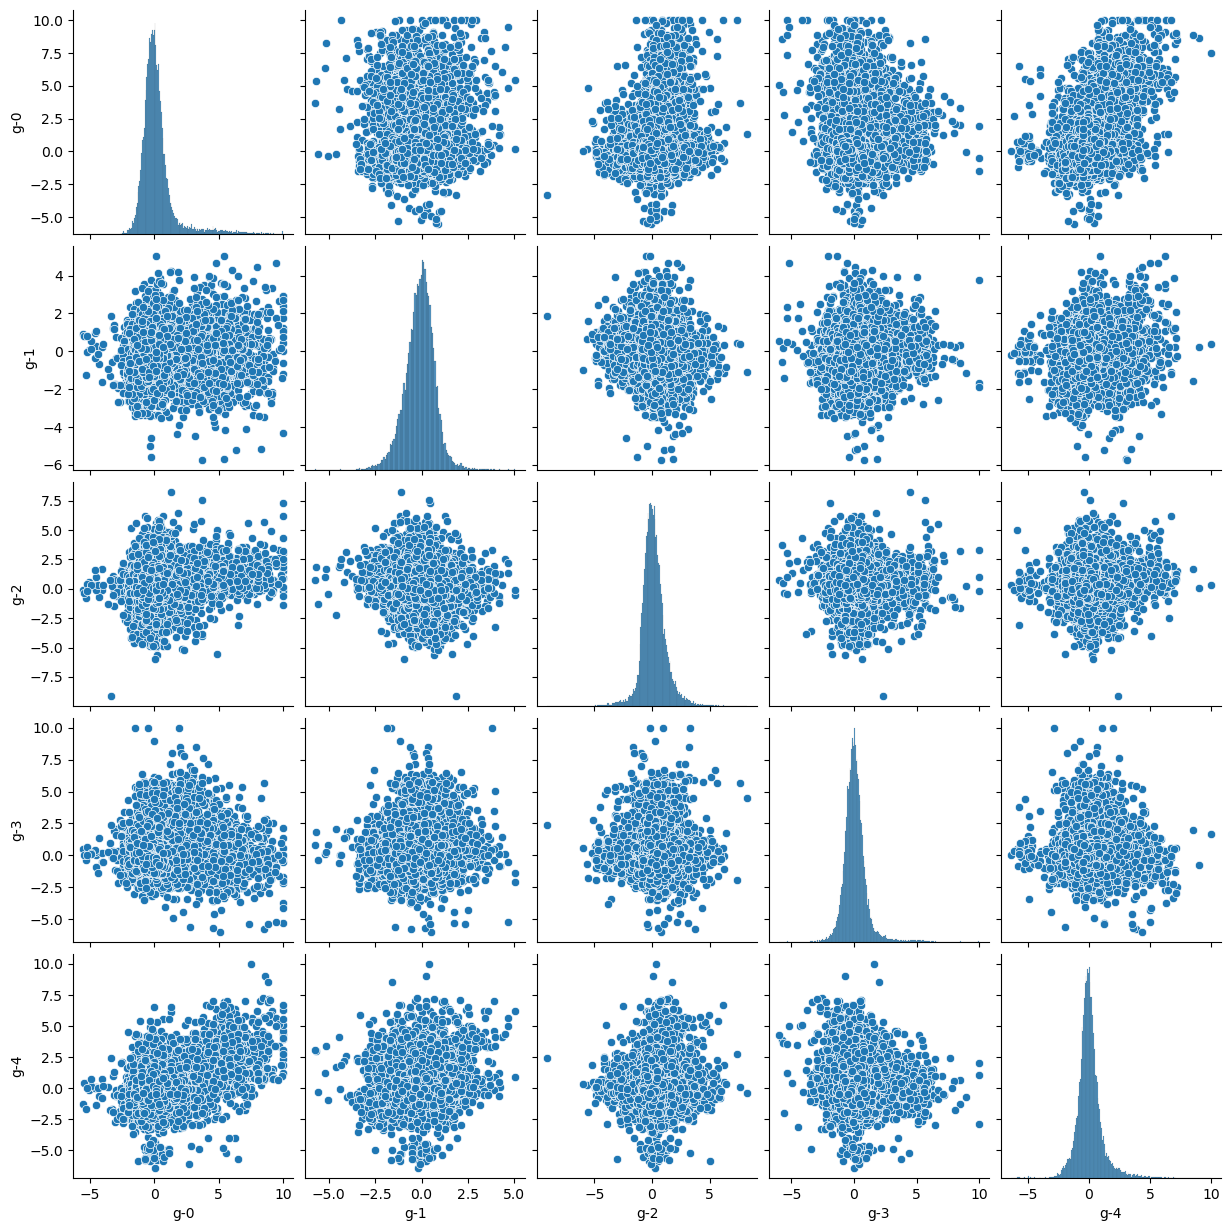

In [6]:
sns.pairplot(train_features[gexp_cols[:5]])

Gexp features look to be gaussian-distributed with mean ~0. Some of them have tails (e.g. g-0). At least in these first 5 genes no correlations seems obvious.

In [7]:
def my_heatmap(input_features):
    corr_gexp = input_features.corr()
    g = sns.clustermap(corr_gexp, figsize=(5, 5), cmap='RdBu_r', vmin=-1, vmax=1)
    mask = np.triu(np.ones_like(corr_gexp))
    values = g.ax_heatmap.collections[0].get_array().reshape(corr_gexp.shape)
    new_values = np.ma.array(values, mask=mask)
    g.ax_heatmap.collections[0].set_array(new_values)
    g.ax_col_dendrogram.set_visible(False)
    g.ax_heatmap.set(yticklabels=[])
    g.ax_heatmap.tick_params(right=False)
    g.ax_cbar.set_position([0.7, 0.6, 0.03, 0.1])

/Users/carlo.dedonno/miniconda3/envs/scpoli/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


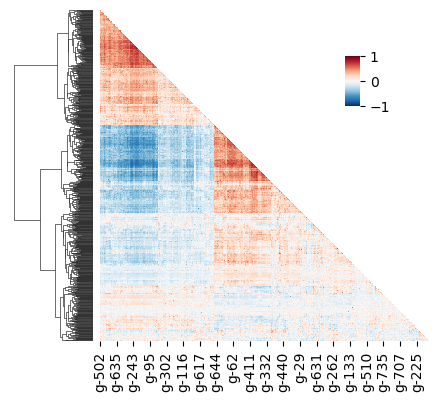

In [8]:
my_heatmap(train_features[gexp_cols])


There are two fairly large groups of genes with correlated expressions. 

### Viability features exploration

Each feature measures the viability of the drug on a certain cell type. With values > 0 indicating proliferation, values < 0 a decreased proliferation rate or even death.

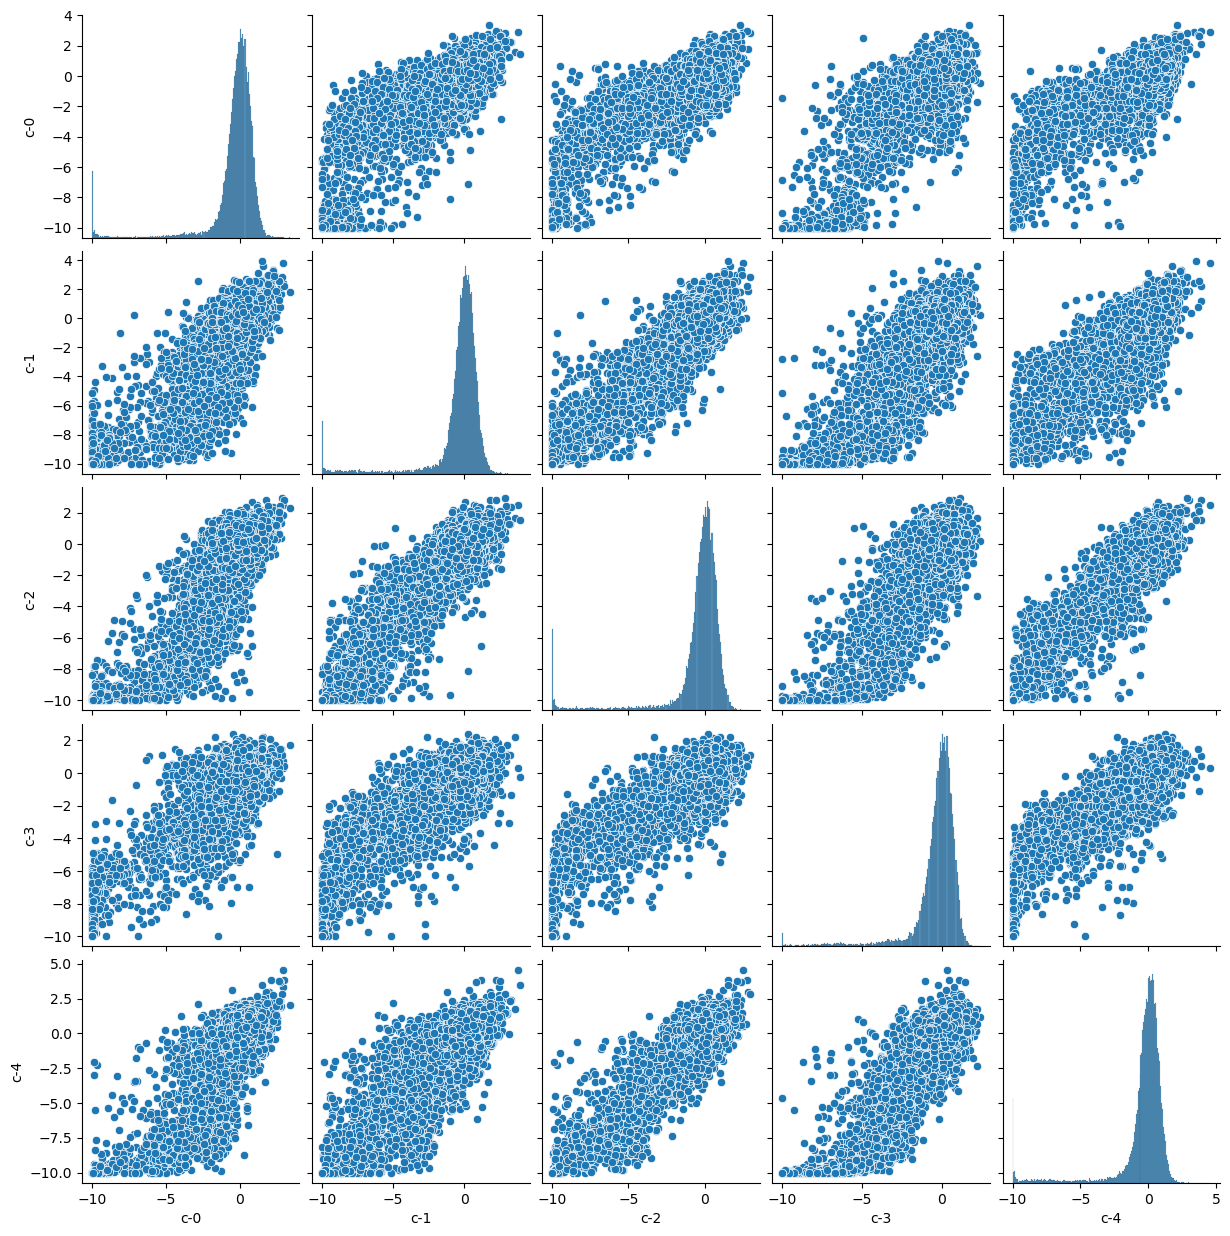

In [9]:
sns.pairplot(train_features[viability_cols[:5]])

Viability features appear to have a lower bound at -10. They have a peak around 0, but distinct tails towards negative values. Correlations are evident.

/Users/carlo.dedonno/miniconda3/envs/scpoli/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


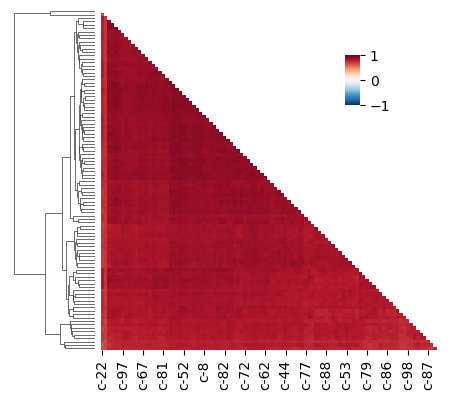

In [10]:
my_heatmap(train_features[viability_cols])

It would appear all viability features are heavily correlated with each other.

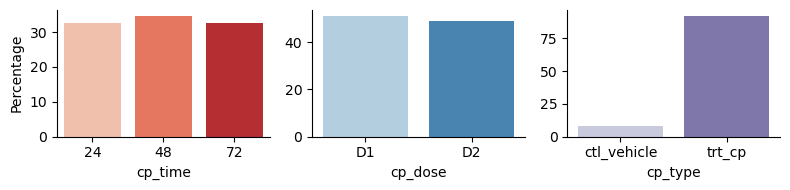

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2))
d = train_features.groupby('cp_time').size() / len(train_features) * 100
sns.barplot(x=d.index, y=d.values, ax=ax[0], palette='Reds')
d = train_features.groupby('cp_dose').size() / len(train_features) * 100
sns.barplot(x=d.index, y=d.values, ax=ax[1], palette='Blues')
d = train_features.groupby('cp_type').size() / len(train_features) * 100
sns.barplot(x=d.index, y=d.values, ax=ax[2], palette='Purples')
sns.despine()
ax[0].set_ylabel("Percentage")
plt.tight_layout()

Dosage and treatment time classes are balanced, there are about 9% vehicle data points.

In [12]:
pd.crosstab(train_features['cp_time'], train_features['cp_dose'])

cp_dose,D1,D2
cp_time,,
24,3886,3886
48,4354,3896
72,3907,3885


In [13]:
pd.crosstab(train_features['cp_type'], train_features['cp_time'])

cp_time,24,48,72
cp_type,,,
ctl_vehicle,606,648,612
trt_cp,7166,7602,7180


In [14]:
pd.crosstab(train_features['cp_type'], train_features['cp_dose'])

cp_dose,D1,D2
cp_type,,
ctl_vehicle,951,915
trt_cp,11196,10752


Classes are balanced also across values, no interactions visible.

## Target data exploration

In [15]:
train_targets_scored

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_000779bfc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_000a6266a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_0015fd391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_001626bd3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id_fffb1ceed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_fffb70c0c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_fffc1c3f4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
train_targets_scored.isin([0, 1]).all().all()

True

The targets are binary labels.

Text(0, 0.5, 'Percentage')

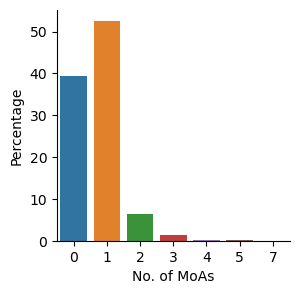

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
d = train_targets_scored.sum(axis=1).value_counts() / len(train_targets_scored) * 100
sns.barplot(x=d.index, y=d.values, ax=ax)
sns.despine()
ax.set_xlabel('No. of MoAs')
ax.set_ylabel('Percentage')

Most drugs have 1 MoA, some have multiple, a few of them even up to 7. There is also a very big group with no mode of action assigned.

# PCA visualization 

In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(n_components=10)
features_transformed = pca.fit_transform(train_features[gexp_cols])

In [26]:
def pca_plot(features_transformed, train_features, color_cat, pca_object, palette, ax):
    sns.scatterplot(
        x=features_transformed[:, 0], 
        y=features_transformed[:, 1], 
        hue=train_features[color_cat], 
        s=10, 
        alpha=0.7,
        ax=ax,
        palette=palette
    )
    ax.set_xlabel(f'PC1 (var={pca_object.explained_variance_ratio_[0] * 100:.1f}%)')
    ax.set_ylabel(f'PC2 (var={pca_object.explained_variance_ratio_[1] * 100:.1f}%)')

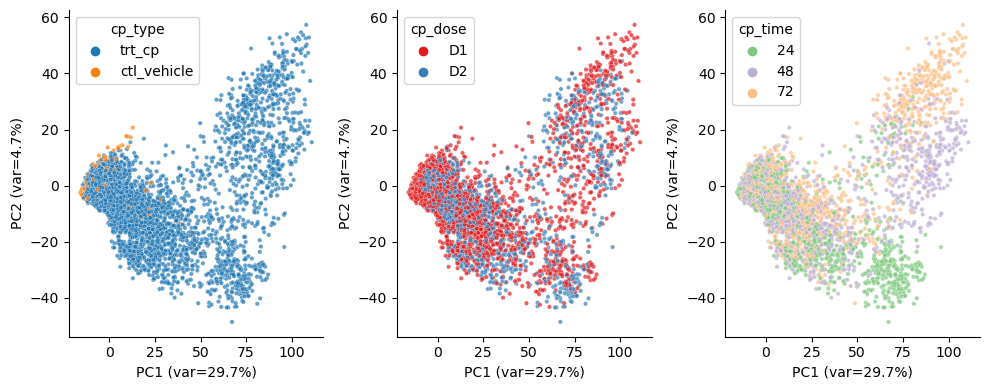

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
pca_plot(features_transformed, train_features, 'cp_type', pca, 'tab10', ax[0])
pca_plot(features_transformed, train_features, 'cp_dose', pca, 'Set1', ax[1])
pca_plot(features_transformed, train_features, 'cp_time', pca, 'Accent', ax[2])
sns.despine()
plt.tight_layout()

In [28]:
pca = PCA(n_components=10)
features_transformed = pca.fit_transform(train_features[viability_cols])

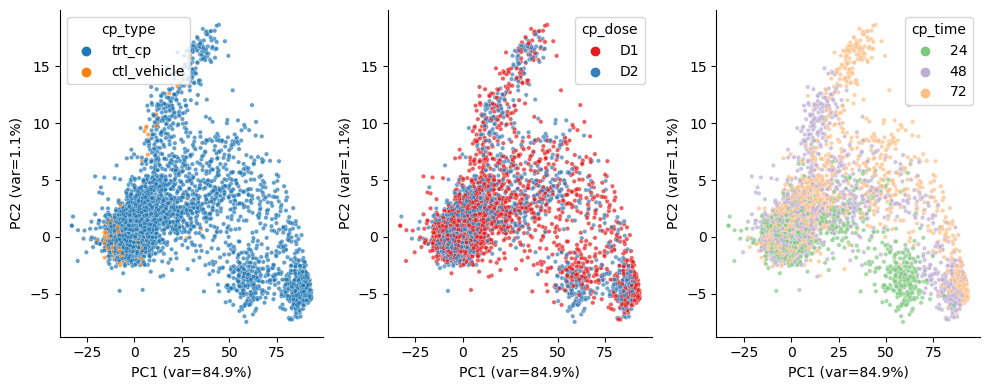

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
pca_plot(features_transformed, train_features, 'cp_type', pca, 'tab10', ax[0])
pca_plot(features_transformed, train_features, 'cp_dose', pca, 'Set1', ax[1])
pca_plot(features_transformed, train_features, 'cp_time', pca, 'Accent', ax[2])
sns.despine()
plt.tight_layout()

In [32]:
gexp_cols.

Index(['g-0', 'g-1', 'g-2', 'g-3', 'g-4', 'g-5', 'g-6', 'g-7', 'g-8', 'g-9',
       ...
       'g-762', 'g-763', 'g-764', 'g-765', 'g-766', 'g-767', 'g-768', 'g-769',
       'g-770', 'g-771'],
      dtype='object', length=772)

In [33]:
pca = PCA(n_components=10)
features_transformed = pca.fit_transform(train_features[gexp_cols.to_list() + viability_cols.to_list()])

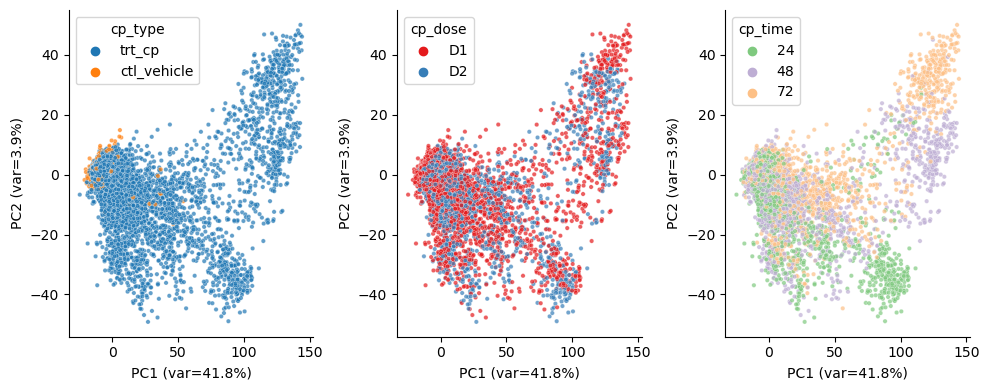

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
pca_plot(features_transformed, train_features, 'cp_type', pca, 'tab10', ax[0])
pca_plot(features_transformed, train_features, 'cp_dose', pca, 'Set1', ax[1])
pca_plot(features_transformed, train_features, 'cp_time', pca, 'Accent', ax[2])
sns.despine()
plt.tight_layout()